# Computed MAF QC

The goal of the analysis is to see how many lead variants from credible sets had correctly calculated MAF.

<div class="alert alert-block alert-info"> 
<b> Reasons of MAF computation failure </b>
    <ul>
        <li><I>majorPopulationMAF == 0.0</I>  - Searched variant was found in gnomAD, but it was not reported for the searched study major population</li>
        <li><I>majorPopulationMAF is Null</I> -  Searched variant was not found in gnomAD, so AF was not reported for any population</li>
    </ul>

 </div>


## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [1]:
from gentropy.common.session import Session
from pyspark.sql import functions as f

from manuscript_methods.datasets import LeadVariantEffect


Loading BokehJS ...

In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead-maf-vep"


25/06/22 14:03:28 WARN Utils: Your hostname, mindos resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eno1)
25/06/22 14:03:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/22 14:03:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/22 14:03:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/22 14:03:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
session.spark


In [4]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)


## MAF QC

Ensure that both datasets contain the same amount of rows

<img src="plots/01.2_discrepancies_in_maf_calculation.jpg" width="600">


In [5]:
from manuscript_methods import group_statistics, plot_group_statistics
from manuscript_methods.maf import maf_discrepancies

data = dataset_maf.df.select(maf_discrepancies(f.col("majorLdPopulationMaf.value")))

gs = group_statistics(data, f.col("mafDiscrepancy"))
gs.show()


+--------------------+-------+-----+
|      mafDiscrepancy|  count|    %|
+--------------------+-------+-----+
|Variant has allel...|2821580|99.57|
|Variant missing f...|   9434| 0.33|
|Variant missing f...|   2744| 0.10|
+--------------------+-------+-----+



### Plot

/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.35 x 4.5 in image.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/01.2_discrepancies_in_maf_calculation.jpg


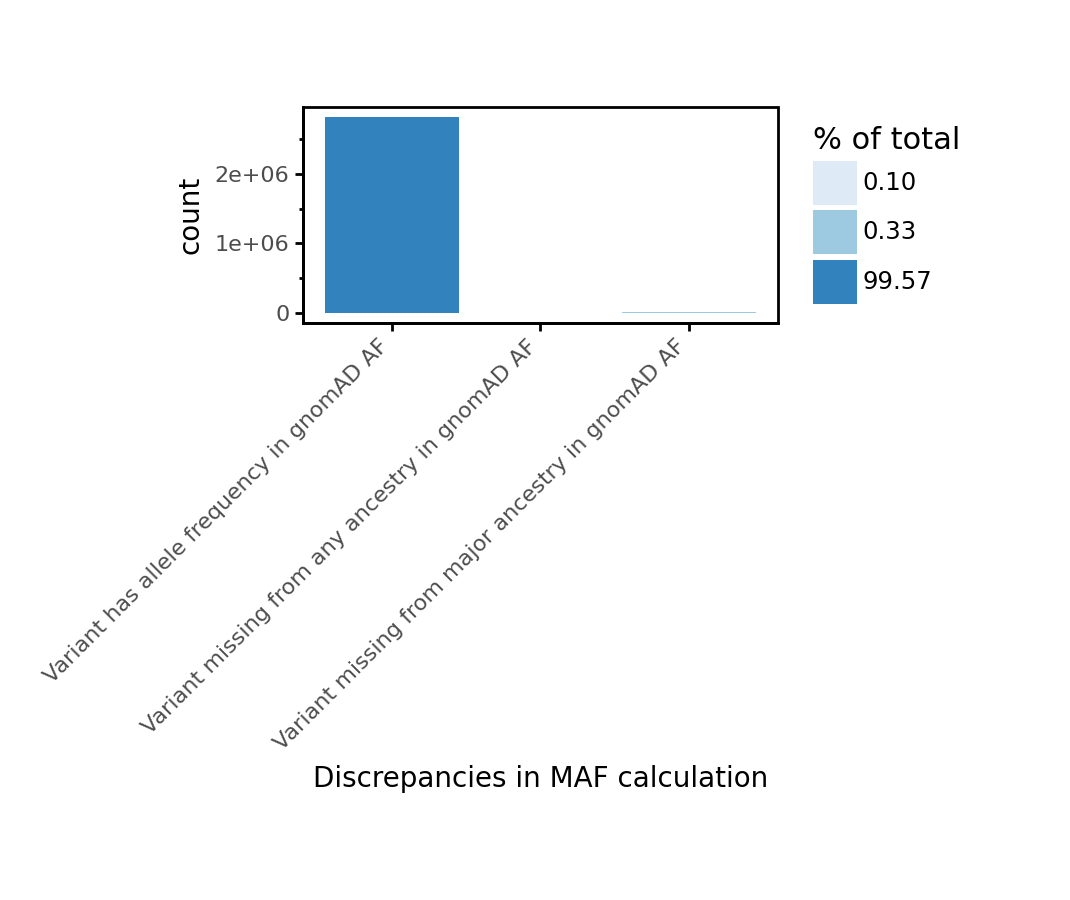

In [9]:
plot = plot_group_statistics(gs, x="mafDiscrepancy", y="count", fill="%", title="Discrepancies in MAF calculation")
plot.save("plots/01.2_discrepancies_in_maf_calculation.jpg", dpi=300, bbox_inches="tight")

plot
